## Task1: 
Apply a Gaussian smoothing operator to the image and display the smoothed image.

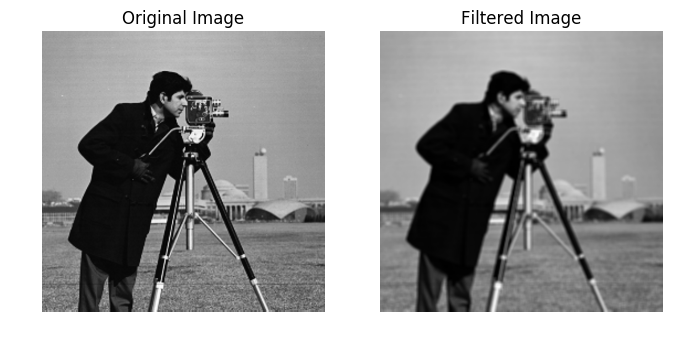

In [61]:
import matplotlib.pyplot as plt
from skimage import data
import numpy as np
import cv2
import scipy
from ipywidgets import interact, fixed, FloatSlider, IntSlider,FloatRangeSlider, Label

#gaussian filter function
def gaussian_filter(original_image,sigma,size):
    fig1, axes_array = plt.subplots(1, 2)
    fig1.set_size_inches(8,4)
    global filtered_image
    if(sigma!=0):
        filtered_image=  cv2.GaussianBlur(original_image,(size,size),sigma)
    else:
        filtered_image = original_image
    image_plot = axes_array[0].imshow(original_image,cmap=plt.cm.gray)
    image_plot = axes_array[1].imshow(filtered_image,cmap=plt.cm.gray) 
    axes_array[0].axis('off')
    axes_array[0].set(title='Original Image')
    axes_array[1].axis('off')
    axes_array[1].set(title='Filtered Image')
    plt.show()

#get image
cameraman_image = data.camera()/255.
interact(gaussian_filter,original_image=fixed(cameraman_image),
         sigma=FloatSlider(min=0, max=10.0, step=0.1,value =5,continuous_update=False),
        size=IntSlider(min=1, max=101, step=2,value = 7,continuous_update=False)); 


## Task2:
Apply Sobel operator to the smoothed image and display the magnitude and the direction of the edges as two separate images.

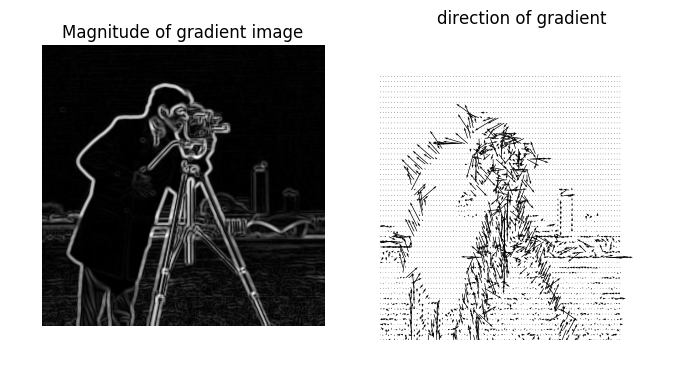

In [62]:
horizontal_kernel = np.array([[ 1.,  2,  1],[ 0,  0,  0],[-1,-2,-1]])
vertical_kernel = np.array([[ -1.,  0,  1],[ -2,  0,  2],[-1,0,1]])


# Normalize the kernels
kernel_sum=abs(np.sum(horizontal_kernel))
horizontal_kernel= horizontal_kernel/kernel_sum if kernel_sum else horizontal_kernel
kernel_sum=abs(np.sum(vertical_kernel))
vertical_kernel= vertical_kernel/kernel_sum if kernel_sum else vertical_kernel

#convolving sobel operator with gaussian filtered result 
horizontal_edge_image = scipy.ndimage.convolve(filtered_image, horizontal_kernel)
vertical_edge_image = scipy.ndimage.convolve(filtered_image, vertical_kernel)

#getting gradient magnitude
mag = np.hypot(horizontal_edge_image,vertical_edge_image)

fig1, axes_array = plt.subplots(1, 2)
fig1.set_size_inches(8,4)

#creating meshgrid
x = np.arange(0, mag.shape[0], 1)
y =  np.arange(0, mag.shape[1], 1)
y=y[::-1]
XX, YY = np.meshgrid(x,y)


skip = (slice(None, None, 10), slice(None, None, 6))
axes_array[0].axis("off")
axes_array[1].axis("off")
axes_array[0].set(title='Magnitude of gradient image')
axes_array[1].set(title='direction of gradient')
image_plot = axes_array[0].imshow(mag,cmap=plt.cm.gray)
image_plot = axes_array[1].quiver(XX[skip],YY[skip],horizontal_edge_image[skip],vertical_edge_image[skip])
plt.show()

## Task3:
Apply the non-maximum suppression algorithm and display the result as a gray scale image.

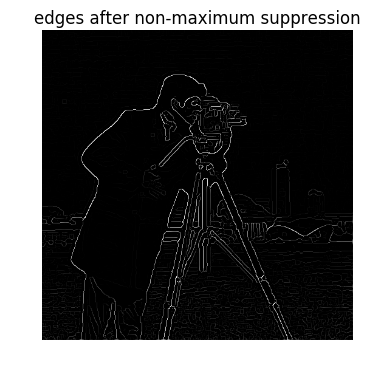

In [63]:
#direction of gradient
theta = scipy.arctan2(vertical_edge_image,horizontal_edge_image)
theta = theta*(180/np.pi);
mag = mag*255


#Quantizing the direction into 4 directions
        
#horizontal
theta[((theta<=-157.5)+(theta>-22.5)*(theta<=22.5)+(theta>157.5)) == True] = 0

#NE-SW
theta[((theta>-157.5)*(theta<=-112.5)+(theta>22.5)*(theta<=67.5)) == True] = 45

#vertical
theta[((theta>-112.5)*(theta<=-67.5) +(theta>67.5)*(theta<=112.5)) == True] = 90

#NW-SE
theta[((theta>-67.5)*(theta<=-22.5) +(theta>112.5)*(theta<=157.5)) == True] = 135



gradient_Supressed = mag.copy()
x,y= mag.shape

''''
applying non-maximum suppression:
if the neihbor pixels in gradient direction greater than current pixel,
make current pixel = 0 

'''

for i in range(x-1):
    for j in range(y-1):
        if (theta[i,j] == 0):
            if (mag[i,j] <= mag[i+1,j]) or (mag[i,j] <= mag[i-1,j]):
                gradient_Supressed[i,j] = 0
        
        elif (theta[i,j] == 45):
            if (mag[i,j] <= mag[i+1,j-1]) or (mag[i,j] <= mag[i-1,j+1]):
                gradient_Supressed[i,j] = 0
        
        elif (theta[i,j] == 90):
            if (mag[i,j] <= mag[i,j+1]) or (mag[i,j] <= mag[i,j-1]):
                gradient_Supressed[i,j] = 0
                
        elif (theta[i,j] == 135):
            if (mag[i,j] <= mag[i+1,j+1]) or (mag[i,j] <= mag[i-1,j-1]):
                gradient_Supressed[i,j] = 0

plt.axis("off") 
plt.title('edges after non-maximum suppression')
image_plot3 = plt.imshow(gradient_Supressed,cmap=plt.cm.gray)
plt.show()


## Task4:
Apply the double threshold algorithm and display the result as a binary image

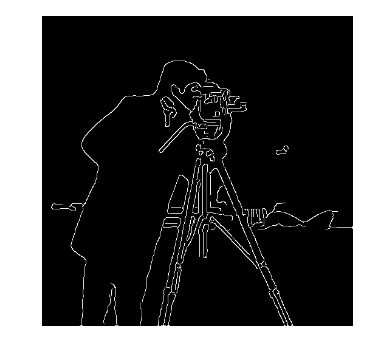

In [64]:
#Applying double threshold
def doubleThreshold(gradient_Sup,Threshold):
    lowerThreshold = Threshold[0]
    upperThreshold = Threshold[1]
    
    #take all edges greater than upper threshold as strong edges
    strongEdges = (gradient_Sup > upperThreshold)
    
    #final edges
    resultEdges = strongEdges.copy()
    
    #mark weak edges as 1 and strong edges as 2
    allEdges = np.array(strongEdges, dtype=np.uint8) + (gradient_Supressed > lowerThreshold)

    tracingPixels = []

    '''
    creating 3x3 window marking the neighbors of current pixel.
    If any neigbor(among 8 neighbors) is a strong edge(having value=2),
    mark that pixel in tracing pixel list and add it to resultedges.
    
    '''
    for i in range(1, mag.shape[0]-1):
        for j in range(1, mag.shape[1]-1):
            if allEdges[i, j] == 1:
                Neighbor_window = allEdges[i-1:i+2,j-1:j+2]
                if  Neighbor_window.__contains__(2):
                    tracingPixels.append((i, j))
                    resultEdges[i, j]= 1
    
    '''
    Edge tracking:
    for every current pixel tracing the weak edges  , if they connect to the strong edges
    they form the actual edges and hence marked in finalEdges, otherwise they are removed
    
    '''    
    tracing(tracingPixels,allEdges,resultEdges,mag)
    
    plt.axis('off')
    plt.imshow(resultEdges,cmap=plt.cm.gray)
    plt.show()
        
        
def tracing(tracingPixels,allEdges,resultEdges,mag):
    
    temp = []
    for row, col in tracingPixels :
        for r in range(-1, 2):
            for c in range(-1, 2):
                if r !=0 or c!=0: 
                    
                    #Making sure we are not out of bounds
                    if row+r<mag.shape[0] and col+c<mag.shape[1] :   
                        i = row+r
                        j = col+c
                    if allEdges[i, j] == 1 and resultEdges[i, j] == 0:
                        temp.append((i, j))
                        resultEdges[i, j] = 1
    if(len(tracingPixels)>1):
        tracing(temp,allEdges,resultEdges,mag)
 
   
    
interact(doubleThreshold,gradient_Sup=fixed(gradient_Supressed),
         Threshold=FloatRangeSlider(min=0., max=200., step=0.05,value=[50,100]),
        continuous_update=False);